In [66]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Loading the datatset

In [67]:
# Load the Dataset

train_stances = pd.read_csv("https://raw.githubusercontent.com/mightyTathagata/fake_news_project/main/fnc_dataset/train_stances.csv") #headlines
train_bodies = pd.read_csv("https://raw.githubusercontent.com/mightyTathagata/fake_news_project/main/fnc_dataset/train_bodies.csv") #body
test_stances = pd.read_csv("https://raw.githubusercontent.com/mightyTathagata/fake_news_project/main/fnc_dataset/test_stances.csv")
test_bodies = pd.read_csv("https://raw.githubusercontent.com/mightyTathagata/fake_news_project/main/fnc_dataset/test_bodies.csv")

# Inner Join on the Body ID
merged_train_data = pd.merge(train_stances, train_bodies, on="Body ID")
merged_test_data = pd.merge(test_stances, test_bodies, on="Body ID")

# Shuffle the Dataset
merged_train_data = merged_train_data.sample(frac=0.3)
merged_test_data = merged_test_data.sample(frac=0.3)

### Feature Label Split

In [68]:
# Feature Label Split

y_train = merged_train_data['Stance']
x_train = merged_train_data.drop('Stance', axis=1)
y_test = merged_test_data['Stance']
x_test = merged_test_data.drop('Stance', axis=1)


In [69]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

14992 14992
7624 7624


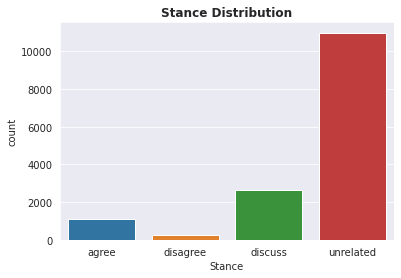

In [70]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()
sns.countplot(x='Stance', data=merged_train_data, order=sorted(merged_train_data['Stance'].unique()), ax=ax)
ax.set_title('Stance Distribution', weight='bold')
plt.show()

### Preprocessing

In [71]:
# Declaring the function
def process_text(text):

    # Lowercasing
    text = text.lower()

    # Remove some punctuations
    text = re.sub(r"[!?,'\"*)@#%(&$_.^-]", '', text)

    # Splitting on spaces
    text = text.split(' ')

    # Stemming and removing spaces
    stemmer_ps = nltk.stem.PorterStemmer()  
    text = [stemmer_ps.stem(word) for word in text if len(word)]

    return " ".join(text)


In [72]:
# Transforming Headlines
x_train['Headline'] = x_train['Headline'].apply(process_text)
x_test['Headline'] = x_test['Headline'].apply(process_text)

# Transforming Body
x_train['articleBody'] = x_train['articleBody'].apply(process_text)
x_test['articleBody'] = x_test['articleBody'].apply(process_text)

In [73]:
tfv_headline = TfidfVectorizer(max_features=2500)

tfv_headline.fit((x_train['Headline']))
xtrain_tfv_headline =  tfv_headline.transform(x_train['Headline'])


xtest_tfv_headline =  tfv_headline.transform(x_test['Headline'])

tfv_body = TfidfVectorizer(max_features=2500)

tfv_body.fit((x_train['articleBody']))
xtrain_tfv_body =  tfv_body.transform(x_train['articleBody'])

xtest_tfv_body =  tfv_body.transform(x_test['articleBody'])



In [74]:
print(xtrain_tfv_headline.shape)
print(xtest_tfv_headline.shape)
print(xtrain_tfv_body.shape)
print(xtest_tfv_body.shape)

(14992, 2500)
(7624, 2500)
(14992, 2500)
(7624, 2500)


In [75]:
xtrain_tfv = hstack([xtrain_tfv_headline, xtrain_tfv_body]).toarray()

xtest_tfv = hstack([xtest_tfv_headline, xtest_tfv_body]).toarray()


### Logistic Regression

In [76]:
clf_lr = LogisticRegression()
clf_lr.fit(xtrain_tfv, y_train)
predictions_lr = clf_lr.predict(xtest_tfv)

In [77]:
lr_f1 = f1_score(y_test, predictions_lr, average='weighted')
lr_recall = recall_score(y_test, predictions_lr, average='weighted')
lr_precision = precision_score(y_test, predictions_lr, average='weighted')

### SVM

In [78]:
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xtest_svd = svd.transform(xtest_tfv)

scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_scl = scl.transform(xtrain_svd)
xtest_scl = scl.transform(xtest_svd)


clf_svm = SVC(C=1.0, probability=True)
clf_svm.fit(xtrain_scl, y_train)
predictions_svm = clf_svm.predict(xtest_scl)



In [79]:
svm_f1 = f1_score(y_test, predictions_svm, average='weighted')
svm_recall = recall_score(y_test, predictions_svm, average='weighted')
svm_precision = precision_score(y_test, predictions_svm, average='weighted')

### Random Forest Classifier

In [80]:
clf_rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
clf_rf.fit(xtrain_tfv, y_train)
predictions_rf = clf_rf.predict(xtest_tfv)


In [81]:
rf_f1 = f1_score(y_test, predictions_rf, average='weighted')
rf_recall = recall_score(y_test, predictions_rf, average='weighted')
rf_precision = precision_score(y_test, predictions_rf, average='weighted')

### Results

In [82]:
F1_score = np.full(3, np.nan)
Recall = np.full(3, np.nan)
Precision = np.full(3, np.nan)
Algorithm = np.array(3)

Algorithm = ["LogisticRegression", "SVM", "Random Forrest"]

F1_score[0] = lr_f1
F1_score[1] = svm_f1
F1_score[2] = rf_f1

Recall[0] = lr_recall
Recall[1] = svm_recall
Recall[2] = rf_recall

Precision[0] = lr_precision
Precision[1] = svm_precision
Precision[2] = rf_precision

Report = pd.DataFrame({"F1-score":F1_score, "Recall":Recall, "Precision":Precision}, index=Algorithm)
Report



,F1-score,Recall,Precision
LogisticRegression,0.612088,0.698452,0.567666
SVM,0.675833,0.752230,0.714183
Random Forrest,0.637902,0.679171,0.609351


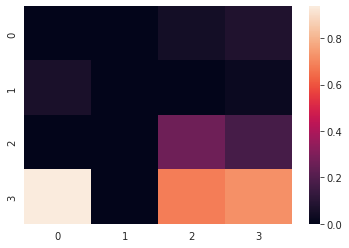

In [95]:
lr_cf_matrix = confusion_matrix(y_test, predictions_lr, normalize='pred')
sns.heatmap(lr_cf_matrix)

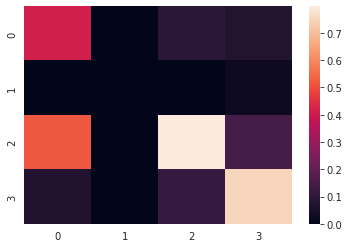

In [96]:
svm_cf_matrix = confusion_matrix(y_test, predictions_svm, normalize='pred')
sns.heatmap(svm_cf_matrix)

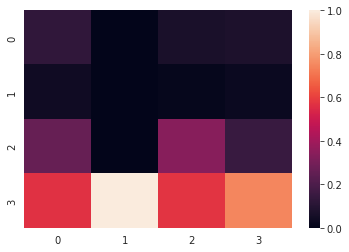

In [97]:
rf_cf_matrix = confusion_matrix(y_test, predictions_rf, normalize='pred')
sns.heatmap(rf_cf_matrix)